In [1]:
# y对x的耐抗线
# 分组的函数
# 分成左，中，右三个组，使得组的大小尽可能相等
get.groups <- function(raw_data){
  # in: raw_data
  # out: group data[list]
  
  # sort
  sort_data <- raw_data[with(raw_data, order(x)), ]
  length_data <- length(raw_data$x)
  # group size
  k <- floor(length_data/3)
  rem_size <- length_data %% 3
  if(rem_size == 0){
    group_data <- list(left=sort_data[c(1:k), ],
                mid=sort_data[c((k+1):(2*k)), ],
                right=sort_data[c((2*k+1):(3*k)), ])
    return(group_data)
  }
  else if (rem_size == 1){
    group_data <- list(left=sort_data[c(1:k), ],
                mid=sort_data[c((k+1):(2*k+1)), ],
                right=sort_data[c((2*k+2):(3*k+1)), ])
    return(group_data)
  }
  else if(rem_size == 2){
    group_data <- list(left=sort_data[c(1:k+1), ],
                mid=sort_data[c((k+2):(2*k+1)), ],
                right=sort_data[c((2*k+2):(3*k+2)), ])
    return(group_data)
  }
}

In [2]:
# 分别获取各组的总括点
get.median.points <- function(group_data){
  median.points <- list(
    left = c(median(group_data$left$x), median(group_data$left$y)),
    mid = c(median(group_data$mid$x), median(group_data$mid$y)),
    right = c(median(group_data$right$x), median(group_data$right$y))
  )
  return(median.points)
}


In [3]:
# 根据总括点获取a, b
get.a.b <- function(median.points){
  xL <- median.points$left[1]
  yL <- median.points$left[2]
  
  xM <- median.points$mid[1]
  yM <- median.points$mid[2]
  
  xR <- median.points$right[1]
  yR <- median.points$right[2]
  
  b0 <- (yR-yL)/(xR-xL)
  a0 <- (1/3)*((yL-b0*(xL-xM)) + yM + (yR-b0*(xR-xM)))
  
  return(c(a0, b0, xM))
}

In [4]:
# 具体应用
# 以儿童身高数据为例
age_data <- c(109, 113, 115, 116, 119, 120,
              121, 124, 126, 129, 130, 133,
              134, 135, 137, 139, 141, 142)

height_data <- c(137.6, 147.8, 136.8, 140.7, 132.7, 145.4,
                 135.0, 133.0, 148.5, 148.3, 147.5, 148.8,
                 133.2, 148.7, 152.0, 150.6, 165.3, 149.9)

raw_data <- data.frame(x=age_data, y=height_data)

group_data <- get.groups(raw_data)
median.points <- get.median.points(group_data)

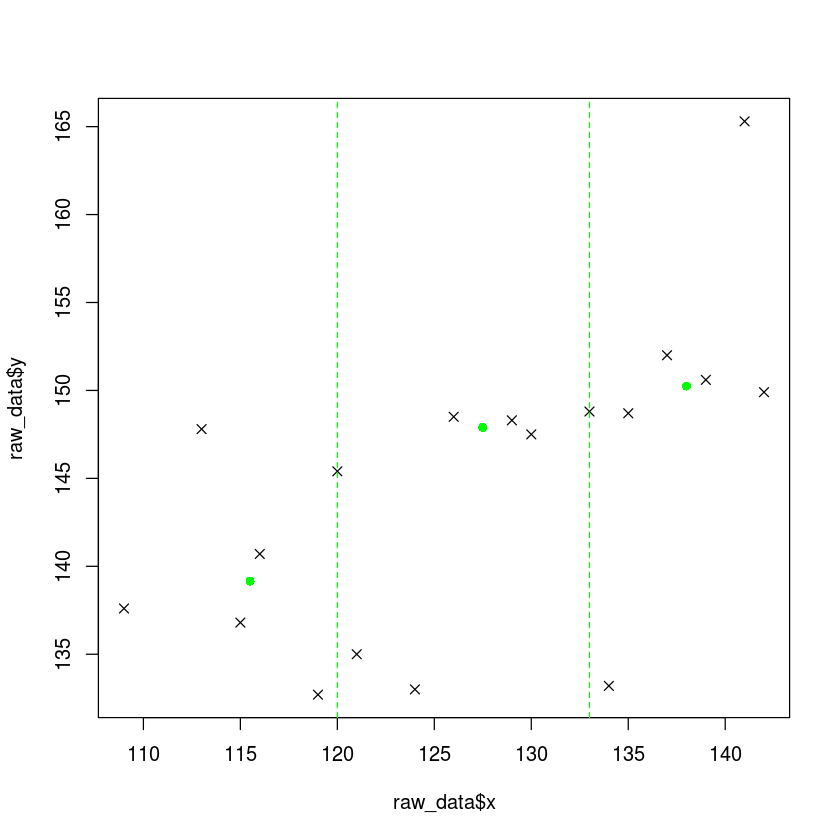

In [5]:
# 原始数据图&初始总括点
plot(raw_data$x, raw_data$y, pch=4)
# 总括点
medians_x <- unlist(median.points)[c(1,3,5)]
medians_y <- unlist(median.points)[c(2,4,6)]
points(medians_x, medians_y, pch=16, col="green")
# 分组线
abline(v=sort(group_data$left$x,decreasing = TRUE)[1], lty=2, col="green")
abline(v=sort(group_data$mid$x,decreasing = TRUE)[1], lty=2, col="green")


In [6]:
# 迭代前的准备

# 传入第一次迭代的模型参数
a0_b0_xM <- get.a.b(median.points)
a0 <- a0_b0_xM[1]
b0 <- a0_b0_xM[2]
xM <- a0_b0_xM[3]
# 初始化迭代参数
iter <- 0
b_abs_delta <- 1

# 迭代限制与收敛条件
MAX_ITER = 100
B_ABS_DELTA = 0.01
b_s <- c(b0)
a_s <- c(a0)


In [7]:
# 开始迭代
while(iter<MAX_ITER && b_abs_delta > B_ABS_DELTA){
  print(b0)
  # 残差代替y,得到新的分组数据
  left_r <- group_data$left$y-(a0+b0*(group_data$left$x-xM))
  mid_r <- group_data$mid$y-(a0+b0*(group_data$mid$x-xM))
  right_r <- group_data$right$y-(a0+b0*(group_data$right$x-xM))
  
  group_data <- list(
    left = data.frame(x=group_data$left$x, y=left_r),
    mid = data.frame(x=group_data$mid$x, y=mid_r),
    right = data.frame(x=group_data$right$x, y=right_r)
  )
  # 计算新的总括点
  median.points <- get.median.points(group_data)
  # 计算新的参数
  a0_b0_xM <- get.a.b(median.points)
  a0 <- a0_b0_xM[1]
  b0 <- a0_b0_xM[2]
  xM <- a0_b0_xM[3]

  a_s <- c(a_s, a0)
  b_s <- c(b_s, b0)
  # 迭代控制
  b_abs_delta <- abs(b0)  # 这里注意是变化量
  iter <- iter + 1
  
}

[1] 0.4933333
[1] -0.07051852


In [8]:
# 迭代结果整理
aFinal <- sum(a_s)
bFinal <- sum(b_s)
fit_model <- function(x){aFinal + bFinal*(x-xM)}

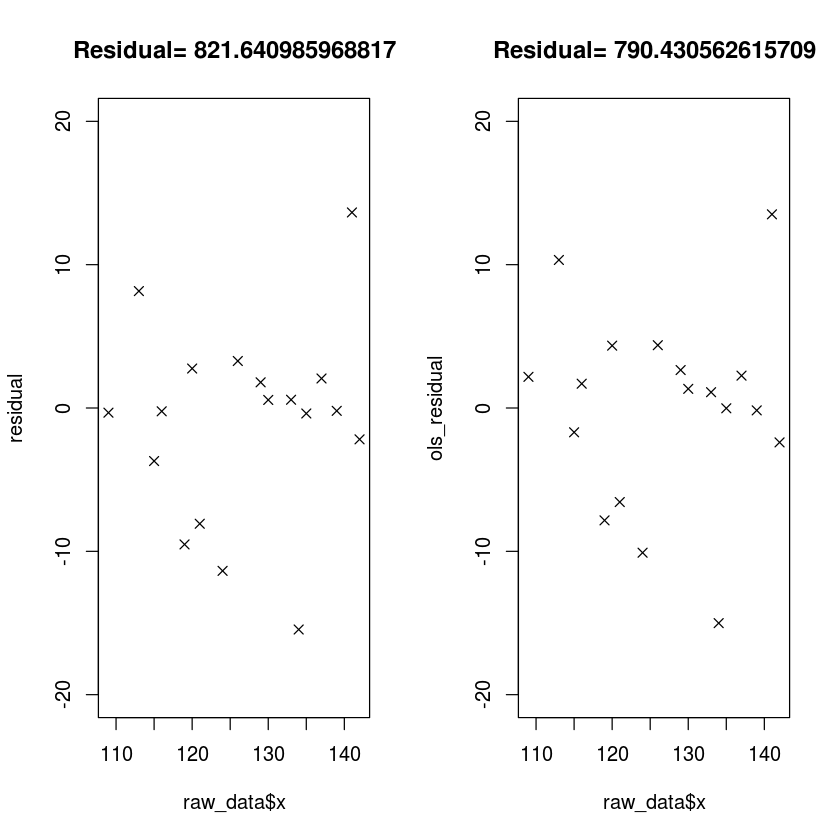

In [11]:
# 耐抗线拟合效果
y_result <- fit_model(raw_data$x)
residual <- raw_data$y - y_result
sum_square_residual <- sum(residual^2)
par(mfrow=c(1,2))
plot(raw_data$x, residual, 
     main = paste("Residual=",as.character(sum_square_residual)),
     pch=4, ylim = c(-20,20))

# 和最小二乘法的比较
ols_fit_model <- lm(y~x, data=raw_data)
ols_residual <- ols_fit_model$residuals
sum_square_residual_ols <- sum(ols_residual^2)
plot(raw_data$x, ols_residual, 
     main = paste("Residual=",as.character(sum_square_residual_ols)),
     pch=4, ylim = c(-20,20))

In [ ]:
# 改进的迭代调整